In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
dict_labels = {
    0: 'glioma_tumor',
    1: 'meningioma_tumor',
    2: 'no_tumor',
    3: 'pituitary_tumor'
}

inv_dict_labels = {v: k for k, v in dict_labels.items()}

In [ ]:
def load_images_labels(path):
    images = []
    labels = []

    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            img = cv2.resize(cv2.imread(image_path), (224, 224))
            images.append(img)
            labels.append(label)

    return images, labels

In [ ]:
#para importar las imagenes
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_train = ('/content/drive/MyDrive/Colab Notebooks/db/Training/')
path_test = ('/content/drive/MyDrive/Colab Notebooks/db/Testing/')


train_img, train_labels = load_images_labels(path_train)
test_img, test_labels = load_images_labels(path_test)

train_img_1 = np.array(train_img)
train_labels_1 = np.array(train_labels)
test_img_1 = np.array(test_img)
test_labels_1 = np.array(test_labels)

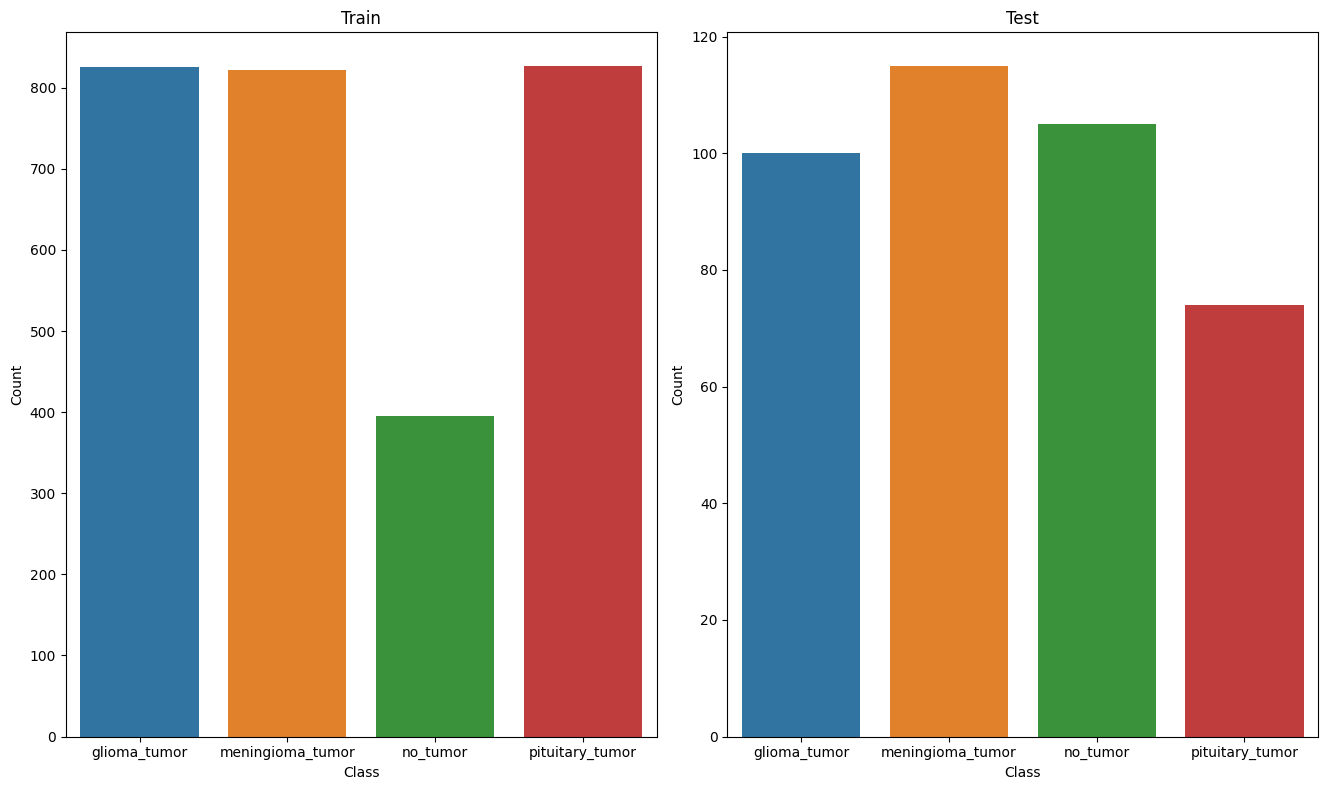

In [ ]:
plt.figure(figsize = (20,8))
lis = ['Train', 'Test']
for i, j in enumerate([train_labels_1, test_labels_1]):
    plt.subplot(1,3,i+1)
    sns.countplot(x = j)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(lis[i])
plt.tight_layout()
plt.show()

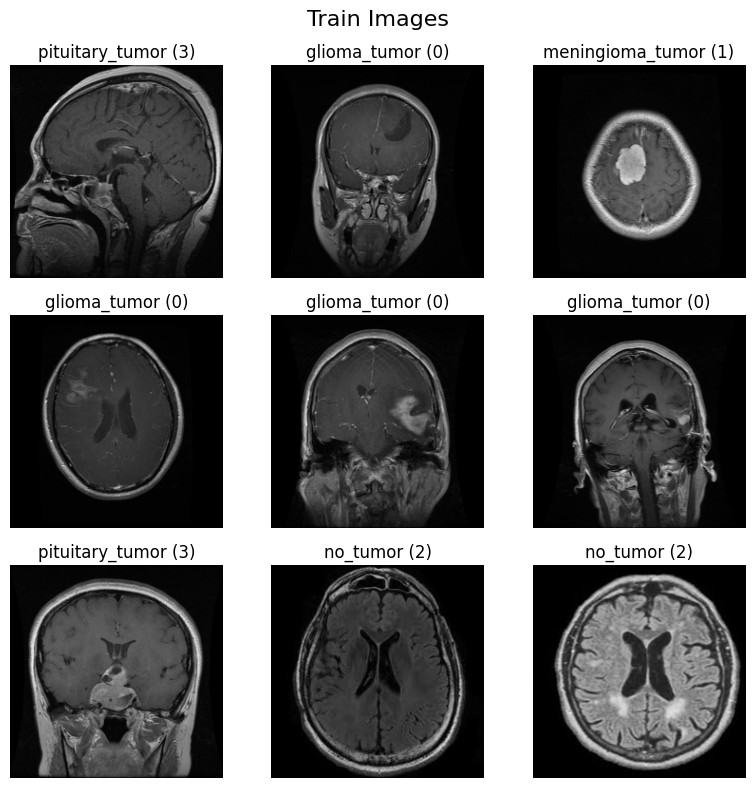

In [ ]:
plt.figure(figsize=(8, 8))
plt.suptitle('Train Images', fontsize=16)
for i in range(9):
    random_index = np.random.randint(0, len(train_img_1))
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_img_1[random_index])
    plt.title(f'{train_labels_1[random_index]} ({inv_dict_labels[train_labels_1[random_index]]})')
    plt.axis("off")
plt.tight_layout()
plt.show()

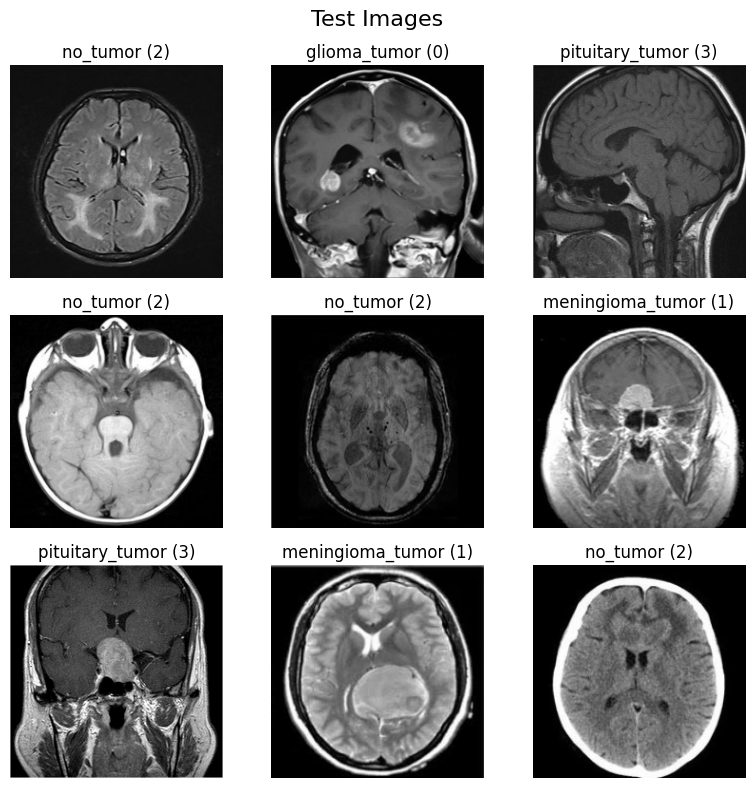

In [ ]:
plt.figure(figsize=(8, 8))
plt.suptitle('Test Images', fontsize=16)
for i in range(9):
    random_index = np.random.randint(0, len(test_img_1))
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_img_1[random_index])
    plt.title(f'{test_labels_1[random_index]} ({inv_dict_labels[test_labels_1[random_index]]})')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Juntar los datos de train y test
all_img = np.concatenate((train_img_1, test_img_1))
all_labels = np.concatenate((train_labels_1, test_labels_1))

# Mezclar los datos
all_img, all_labels = shuffle(all_img, all_labels)

# Divide los datos en train y test
train_img, test_img, train_labels, test_labels = train_test_split(all_img, all_labels, test_size=0.12)

# Divide los datos de train en train y validation
train_img, val_img, train_labels, val_labels = train_test_split(train_img, train_labels, test_size=0.1)

In [ ]:
print("train_img.shape: ", train_img.shape, "\ttrain_labels.shape: ", train_labels.shape, "\nval_img.shape: ", val_img.shape, "\tval_labels.shape: ", val_labels.shape, "\ntest_img.shape: ", test_img.shape, "\ttest_labels.shape: ", test_labels.shape)

train_img.shape:  (2584, 224, 224, 3) 	train_labels.shape:  (2584,) 
val_img.shape:  (288, 224, 224, 3) 	val_labels.shape:  (288,) 
test_img.shape:  (392, 224, 224, 3) 	test_labels.shape:  (392,)


In [ ]:
# Normalización de los datos
train_img = train_img.astype('float32') / 255
val_img = val_img.astype('float32') / 255
test_img = test_img.astype('float32') / 255

In [ ]:
# transformamos las etiquetas a numeros
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
val_labels = le.fit_transform(val_labels)
test_labels = le.fit_transform(test_labels)

# otra forma de transformar las etiquetas a numeros (one hot encoding)
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

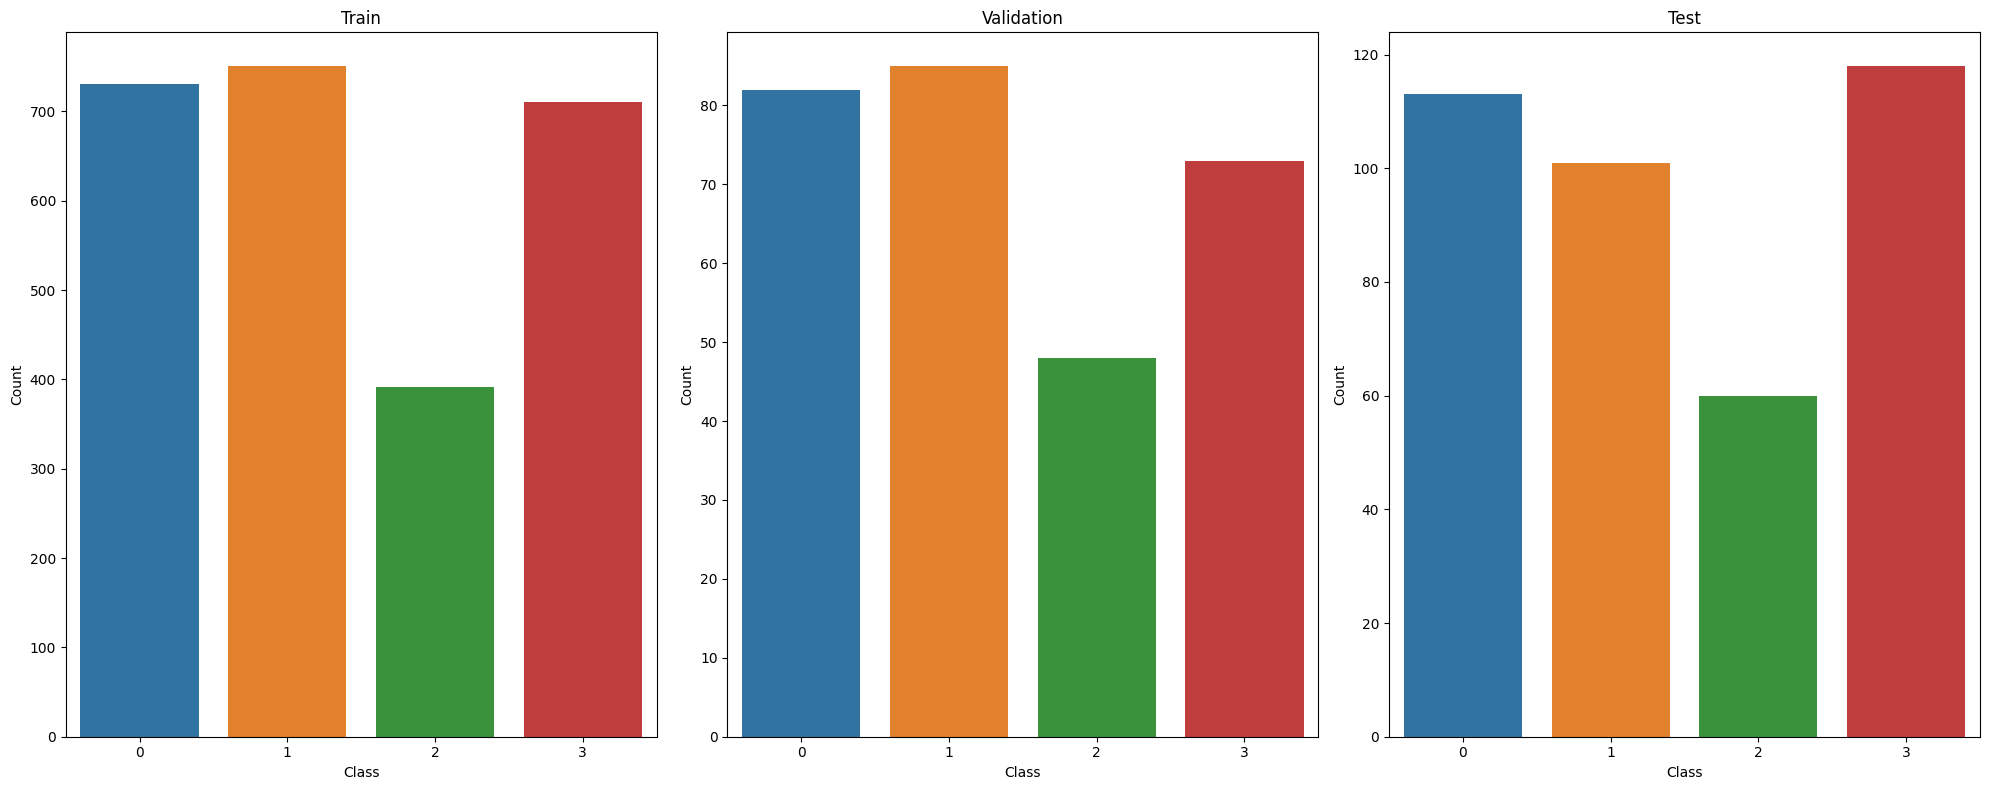

In [ ]:
plt.figure(figsize = (20,8))
lis = ['Train', 'Validation', 'Test']
for i, j in enumerate([train_labels, val_labels, test_labels]):
    plt.subplot(1,3,i+1)
    sns.countplot(x = np.argmax(j, axis=1))
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(lis[i])
plt.tight_layout()
plt.show()

In [ ]:
# Modelo
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=(5, 5), filters=64, activation='relu', padding='same', input_shape=(train_img.shape[1], train_img.shape[2], train_img.shape[3])),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    #tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=64, activation='relu', padding='same'),
    #tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=16, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(68, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# modelo
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=64, activation='relu', padding='same', input_shape=(train_img.shape[1], train_img.shape[2], train_img.shape[3])),
  tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

  tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=64, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

  tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

  tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

  tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=16, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(pool_size=(1, 1)),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40, restore_best_weights=True)

In [ ]:
# Entrenamiento
history = model.fit(train_img, train_labels, epochs=200, batch_size = 16, validation_data=(val_img, val_labels), callbacks=[callback])

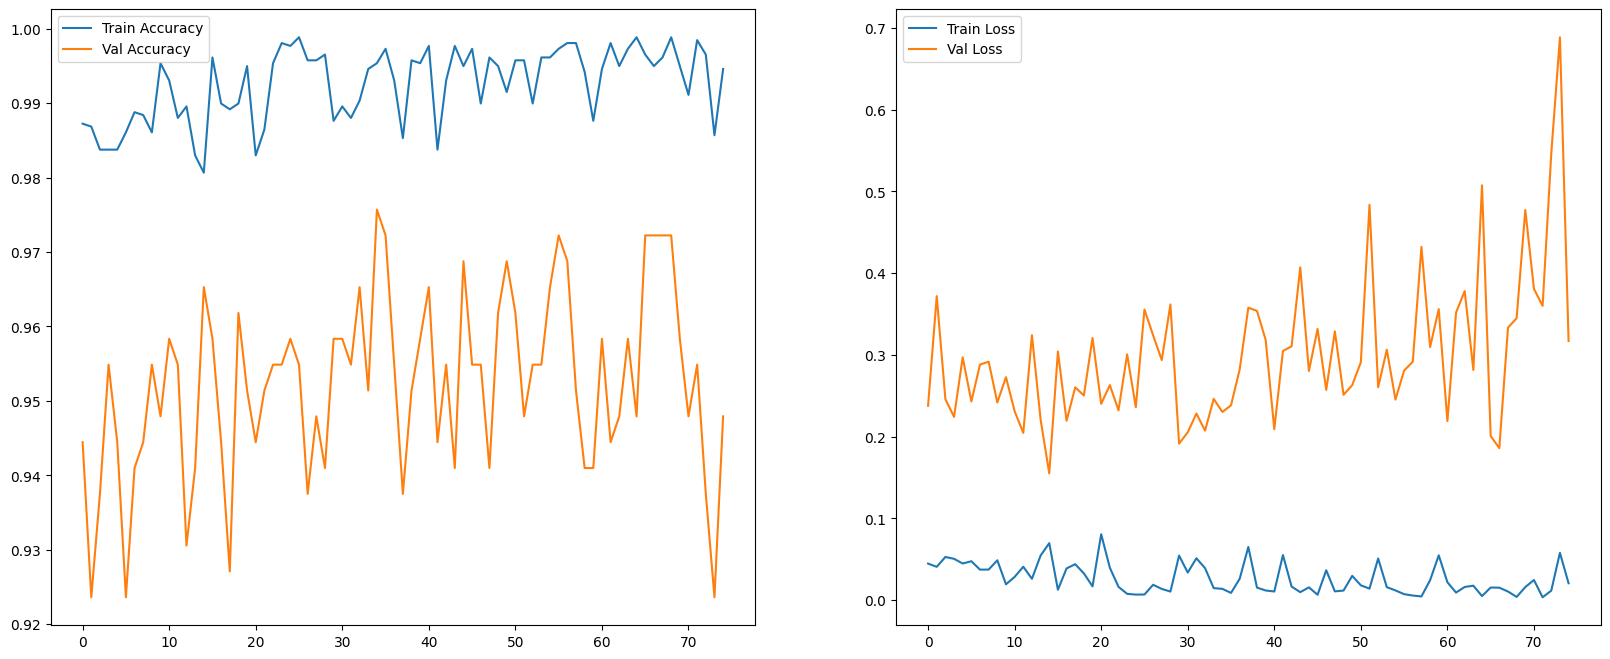

In [ ]:
# Visualización de los resultados
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(test_img)

13/13 [==============================] - 1s 20ms/step


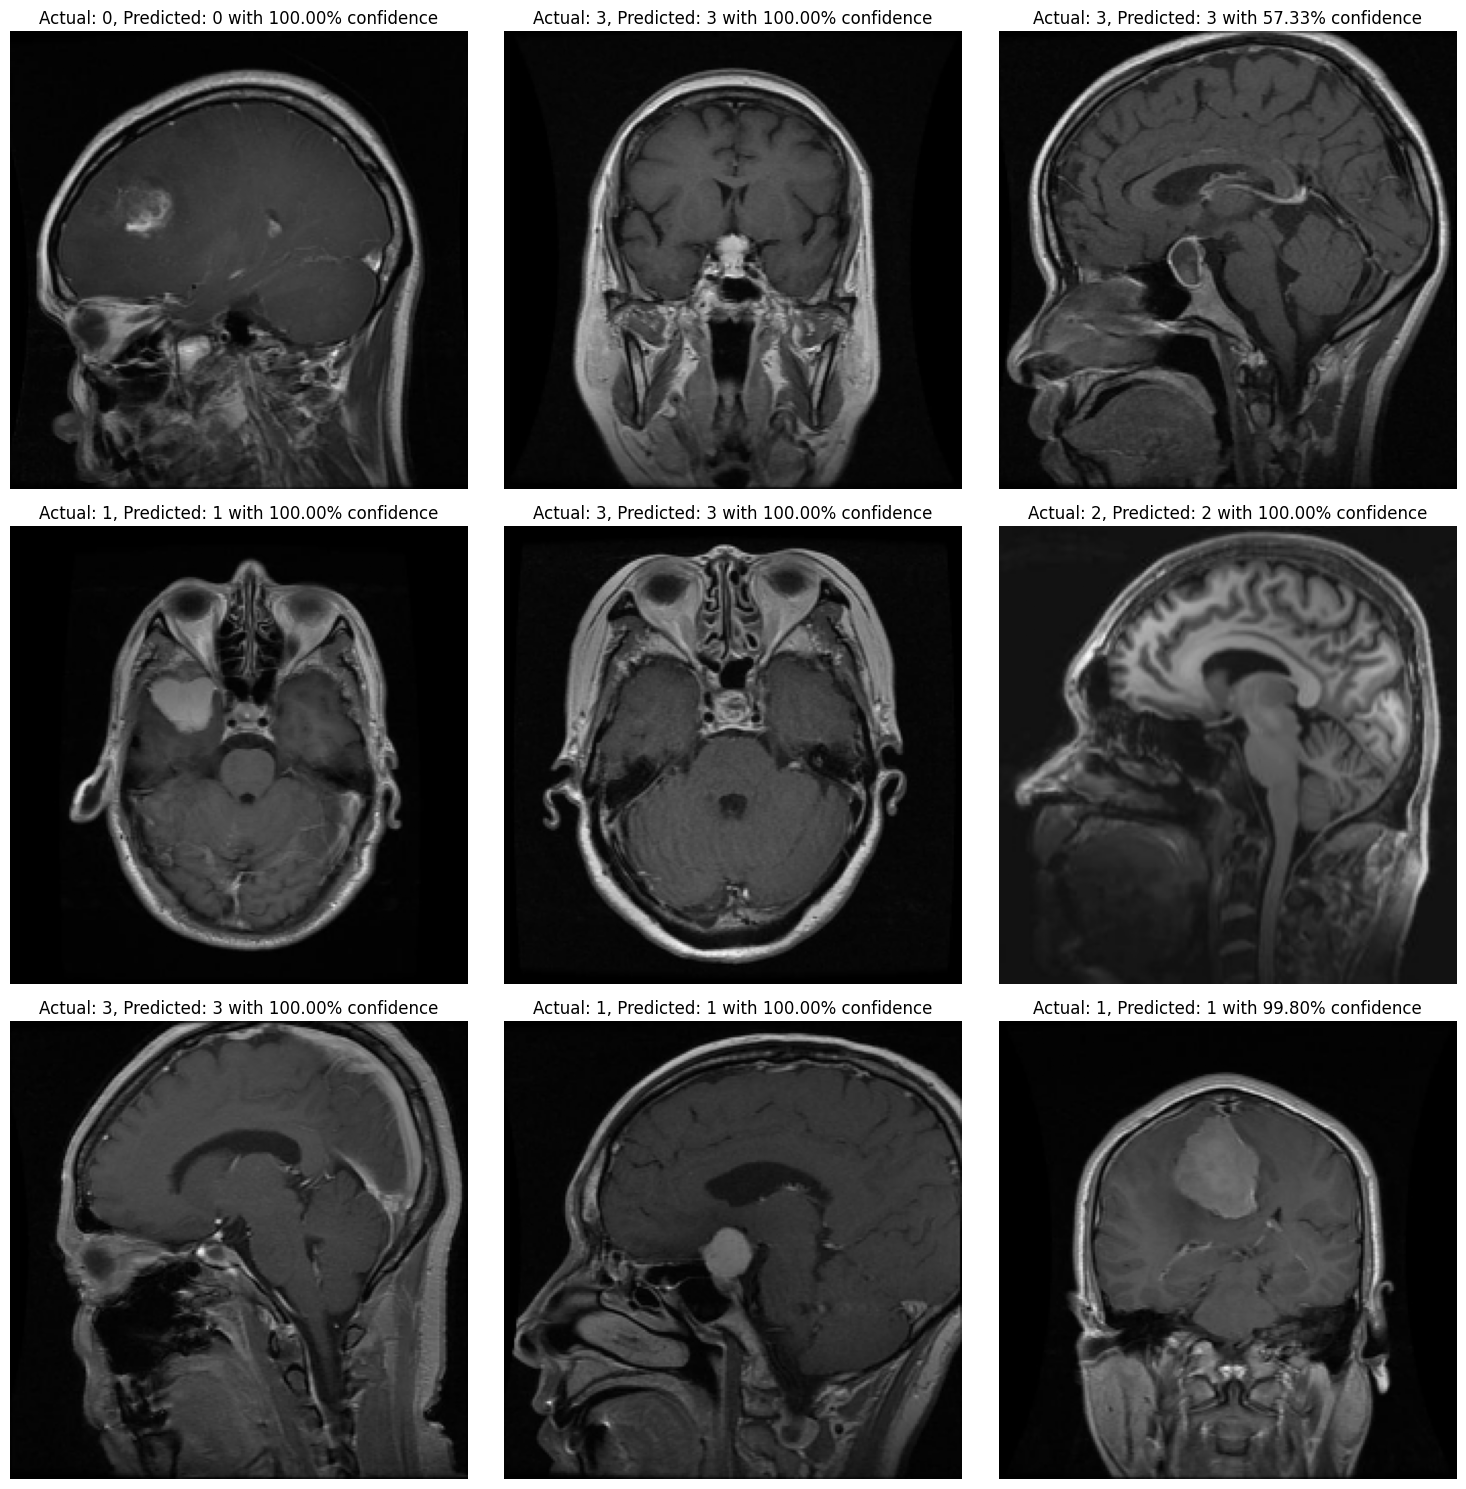

In [ ]:
# Comprobación de las predicciones
plt.figure(figsize=(15,15))
for i in range(9):
    random_index = np.random.randint(0, len(test_img))
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_img[random_index])
    actual_label = np.argmax(test_labels[random_index])
    predicted_label = np.argmax(predictions[random_index])
    plt.title(f'Actual: {actual_label}, Predicted: {predicted_label} with {np.max(predictions[random_index]) * 100:.2f}% confidence')
    plt.axis("off")
plt.tight_layout()
plt.show()

Accuracy Score:  0.9311224489795918


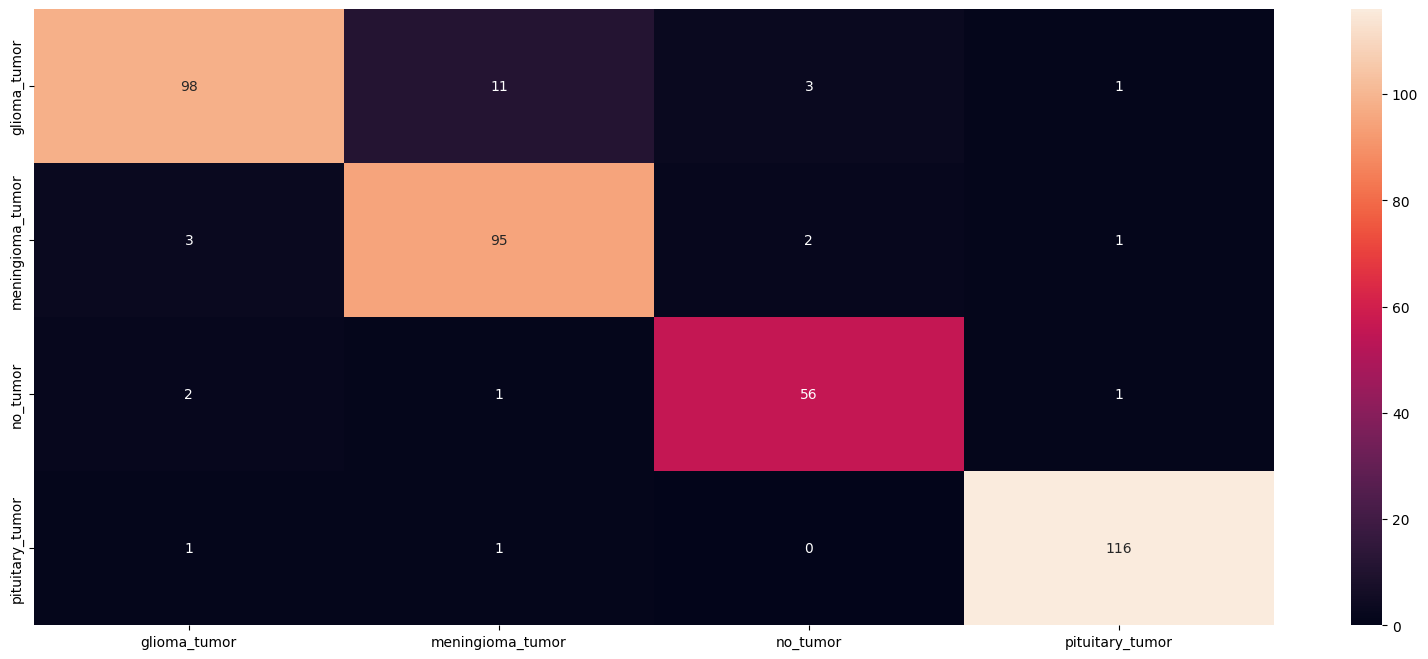

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
test_labels_class = np.argmax(test_labels, axis=1)
predictions_class = np.argmax(predictions, axis=1)
print("Accuracy Score: ", accuracy_score(test_labels_class, predictions_class))
plt.figure(figsize=(20,8))
sns.heatmap(confusion_matrix(test_labels_class, predictions_class), annot=True, fmt='g', xticklabels=dict_labels.values(), yticklabels=dict_labels.values())
plt.show()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 28, 28, 32)       

In [ ]:
# modelo VGG16
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Input
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg16.layers:
    layer.trainable = False
x = Flatten()(vgg16.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(4, activation='softmax')(x)
model = Model(inputs=vgg16.input, outputs=x)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

In [ ]:
history = model.fit(train_img, train_labels, epochs=200, batch_size = 16, validation_data=(val_img, val_labels), callbacks=[callback])

Epoch 1/200
162/162 [==============================] - 21s 98ms/step - loss: 2.0196 - accuracy: 0.2980 - val_loss: 1.3777 - val_accuracy: 0.2951
Epoch 2/200
162/162 [==============================] - 14s 84ms/step - loss: 1.4034 - accuracy: 0.2941 - val_loss: 1.3716 - val_accuracy: 0.2951
Epoch 3/200
162/162 [==============================] - 13s 83ms/step - loss: 1.3787 - accuracy: 0.2783 - val_loss: 1.3684 - val_accuracy: 0.2951
Epoch 4/200
162/162 [==============================] - 13s 82ms/step - loss: 1.3694 - accuracy: 0.2918 - val_loss: 1.3666 - val_accuracy: 0.2951
Epoch 5/200
162/162 [==============================] - 13s 82ms/step - loss: 1.3631 - accuracy: 0.2926 - val_loss: 1.3657 - val_accuracy: 0.2951
Epoch 6/200
162/162 [==============================] - 13s 82ms/step - loss: 1.3593 - accuracy: 0.2945 - val_loss: 1.3652 - val_accuracy: 0.2951
Epoch 7/200
162/162 [==============================] - 13s 83ms/step - loss: 1.3730 - accuracy: 0.2937 - val_loss: 1.3652 - val_ac

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

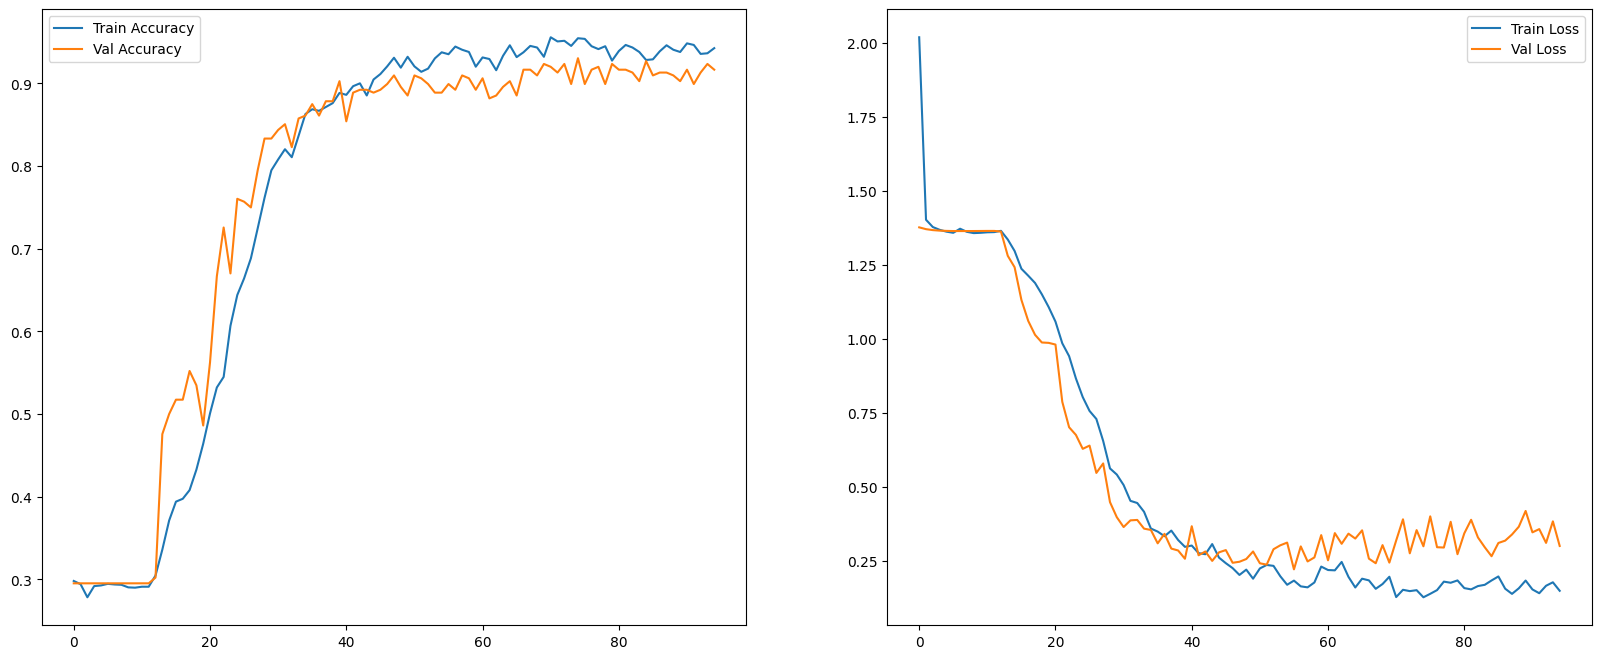

In [ ]:
# Visualización de los resultados
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(test_img)

13/13 [==============================] - 5s 120ms/step


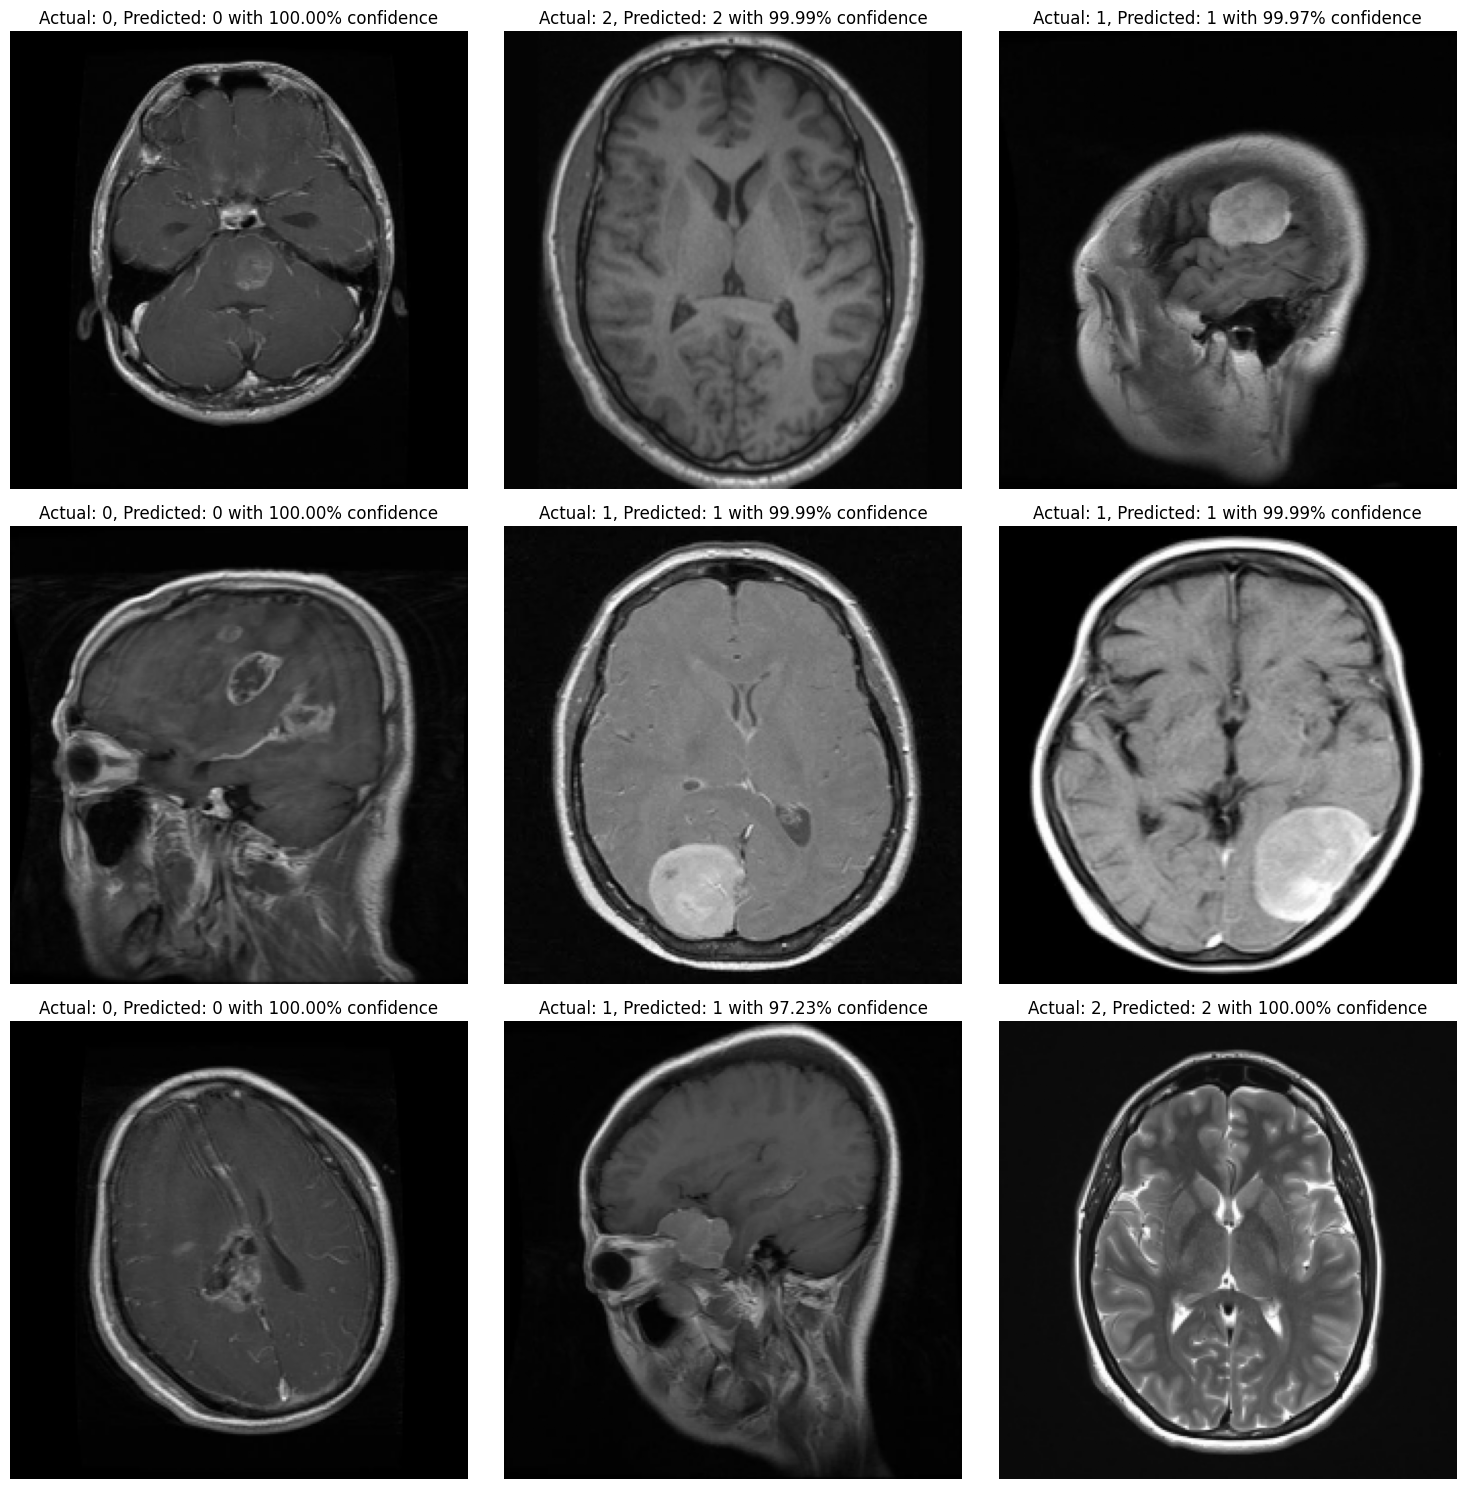

In [ ]:
# Comprobación de las predicciones
plt.figure(figsize=(15,15))
for i in range(9):
    random_index = np.random.randint(0, len(test_img))
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_img[random_index])
    actual_label = np.argmax(test_labels[random_index])
    predicted_label = np.argmax(predictions[random_index])
    plt.title(f'Actual: {actual_label}, Predicted: {predicted_label} with {np.max(predictions[random_index]) * 100:.2f}% confidence')
    plt.axis("off")
plt.tight_layout()
plt.show()

Accuracy Score:  0.9387755102040817


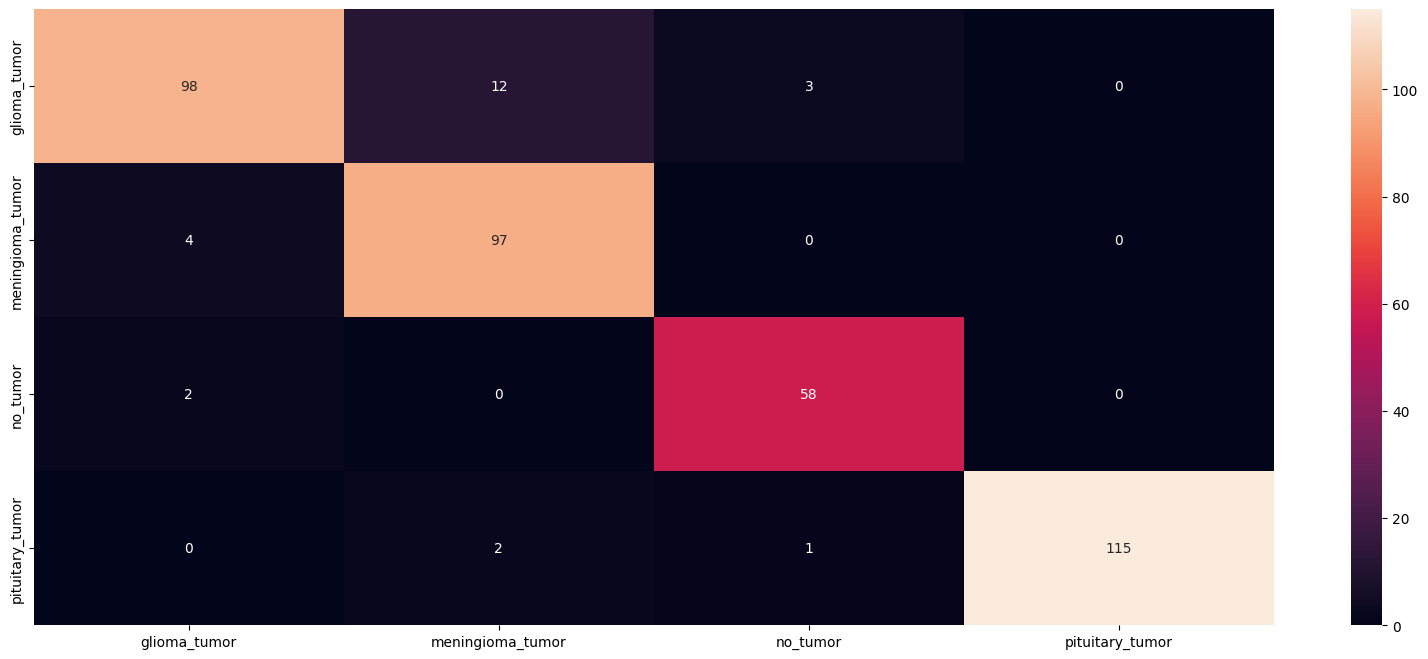

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
test_labels_class = np.argmax(test_labels, axis=1)
predictions_class = np.argmax(predictions, axis=1)
print("Accuracy Score: ", accuracy_score(test_labels_class, predictions_class))
plt.figure(figsize=(20,8))
sns.heatmap(confusion_matrix(test_labels_class, predictions_class), annot=True, fmt='g', xticklabels=dict_labels.values(), yticklabels=dict_labels.values())
plt.show()